# DTSA-5511

Name: Ikram Ali


# Data Gathering & Info

A large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

In this task, I am challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hates. I’ll be using a dataset of comments from Wikipedia’s talk page edits.



Create a model which predicts a probability of each type of toxicity for each comment.

There are rows of data. Where each row has the following data-point. Each comment can be marked for multiple categories. If the comment is toxic and obscene, then for both those headers the value will be 1 and for the others it will be 0.

**File descriptions**

train.csv - the training set, contains comments with their binary labels

test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.

sample_submission.csv - a sample submission file in the correct format

test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)


# Importing Python Libraries

In [127]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import random
import string
import re
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
import transformers
import torch
from torch.utils.data import Dataset, DataLoader 
from transformers import DistilBertTokenizer, DistilBertModel,BertForSequenceClassification, BertTokenizer
import re
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

tqdm.pandas()

# plt.style.use('seaborn')

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/.DS_Store
data/bert_submission.csv
data/test.csv.zip
data/test_labels.csv.zip
data/train.csv.zip


In [60]:
DEFAULT_SEED: int = 1234

random.seed(DEFAULT_SEED)
np.random.seed(DEFAULT_SEED)  
torch.manual_seed(DEFAULT_SEED)
torch.cuda.manual_seed(DEFAULT_SEED)

# Exploratory Data Analysis (EDA)

In [61]:
train_df = pd.read_csv("data/train.csv.zip")
train_df.shape

(159571, 8)

In [62]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [64]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Checking Unique Values

In [65]:
train_df.nunique()

id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64

## Checking Comment Lenght

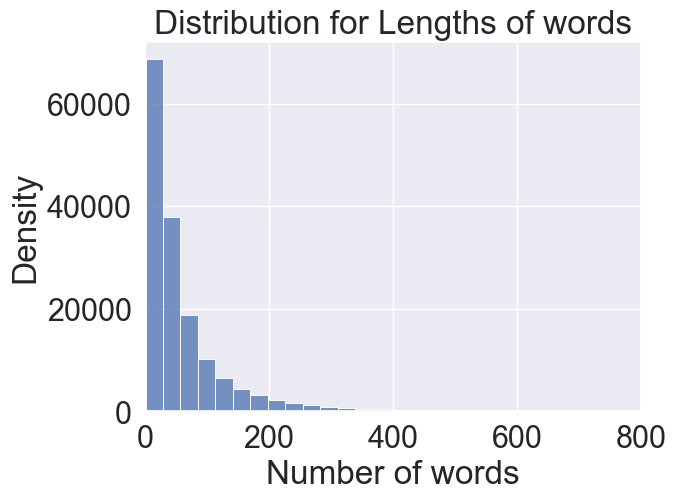

In [66]:
comment_length = train_df['comment_text'].str.split().apply(len)
sns.histplot(comment_length,bins=50,)
plt.title("Distribution for Lengths of words")
plt.xlabel("Number of words")
plt.ylabel("Density")
plt.xlim(0, 800)
plt.show()

## Checking missing values

In [67]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## Clean Comments Count

 - Creating seperate column in dataframe to identify clean comments.
 -We use axis=1 to count row-wise and axis=0 to count column wise

In [68]:
rowSums = train_df.iloc[:,2:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

print("Total number of comments = ",len(train_df))
print("Number of clean comments = ",clean_comments_count)
print("Number of comments with labels =",(len(train_df)-clean_comments_count))

Total number of comments =  159571
Number of clean comments =  143346
Number of comments with labels = 16225


## Calcualte percentage of rows with only zeros in training labels

In [69]:
print(f"{round(clean_comments_count /len(train_df),3)} % percentage of rows contains only zeros in training data")

0.898 % percentage of rows contains only zeros in training data


## Labels

In [70]:
categories = list(train_df.columns.values)
categories = categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


## Calculating Number of Comments in each Category

In [71]:
counts = []
for category in categories:
    counts.append((category, train_df[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


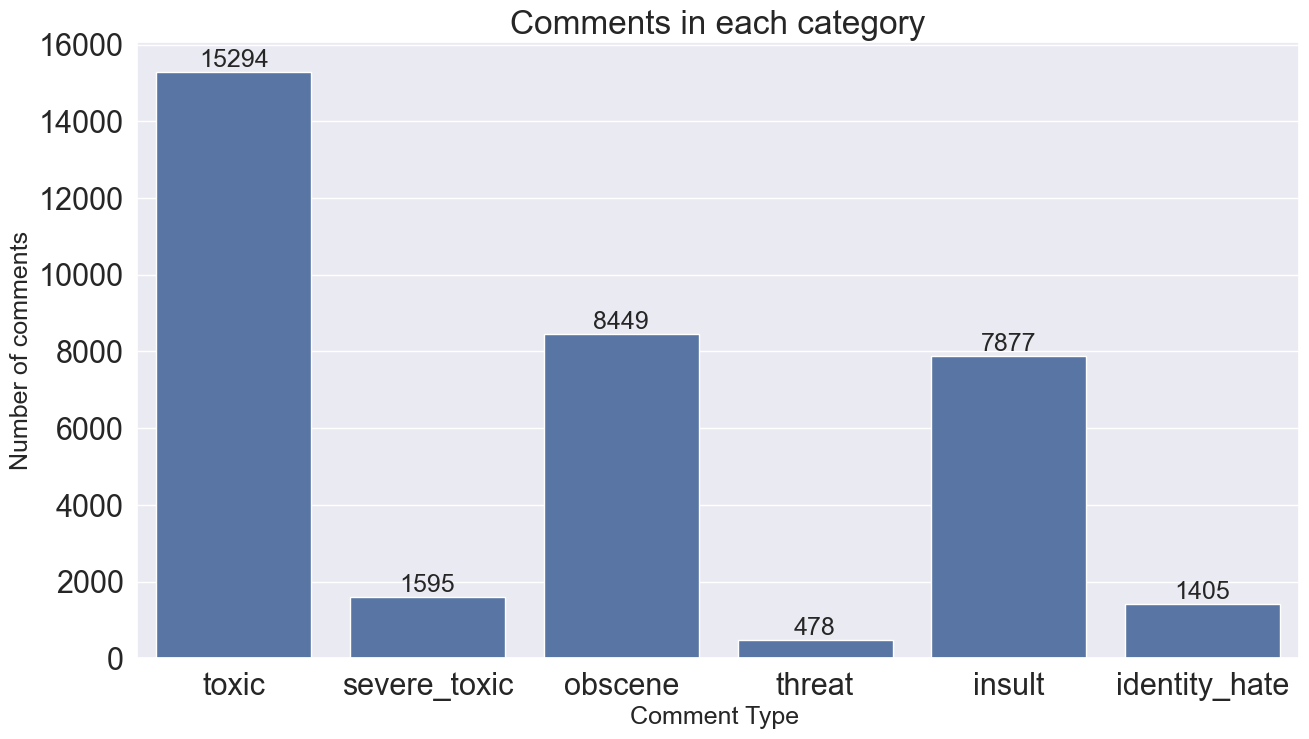

In [72]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(x=categories, y=train_df.iloc[:,2:].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = train_df.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

## Comments having multiple labels

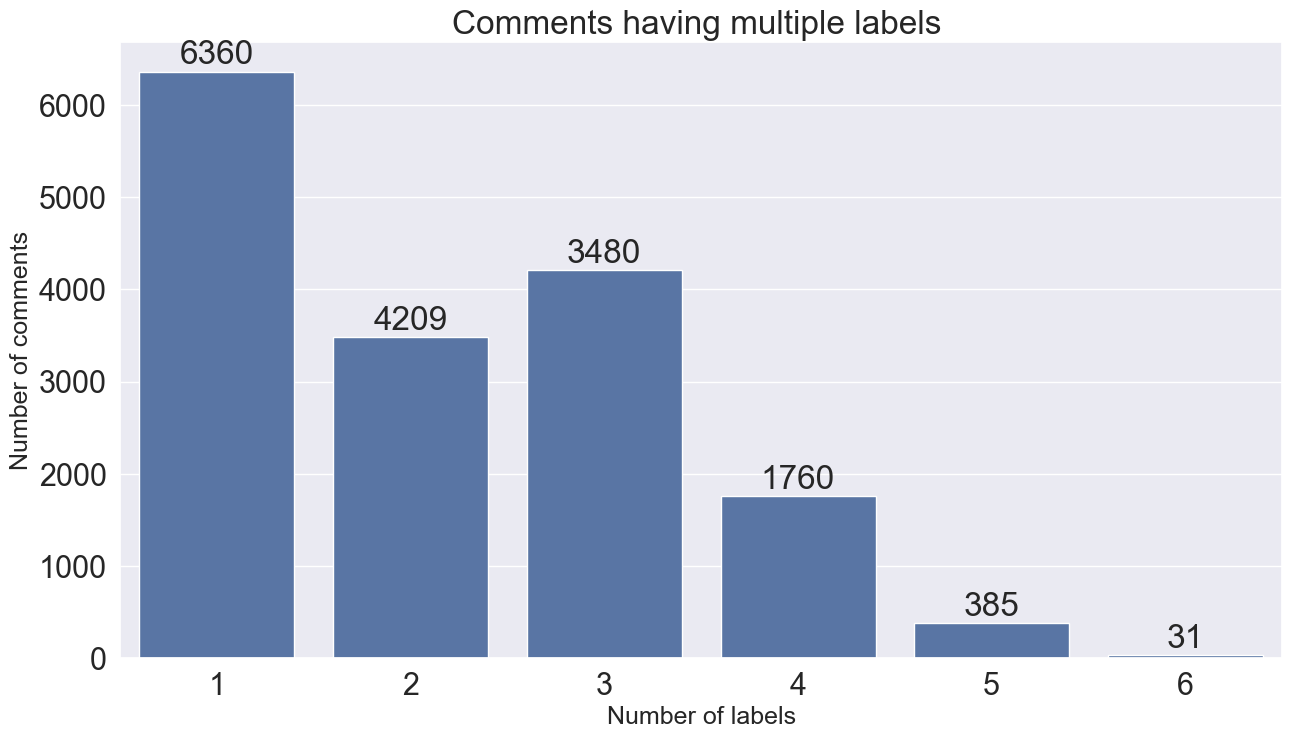

In [73]:
rowSums = train_df.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Most frequent words in the dataset

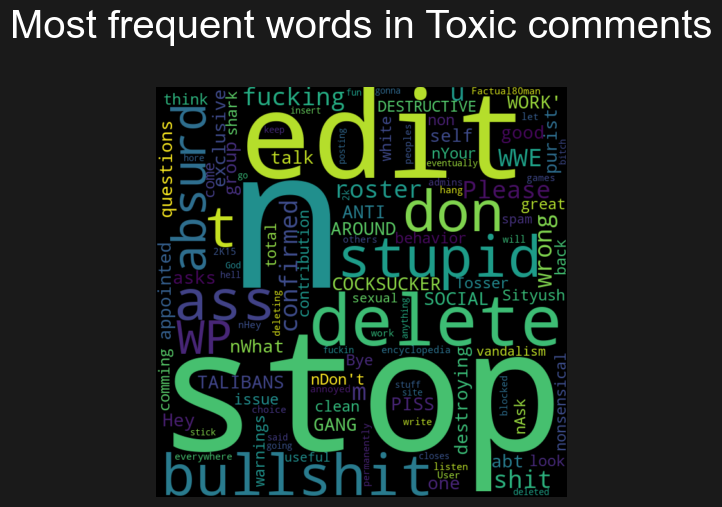

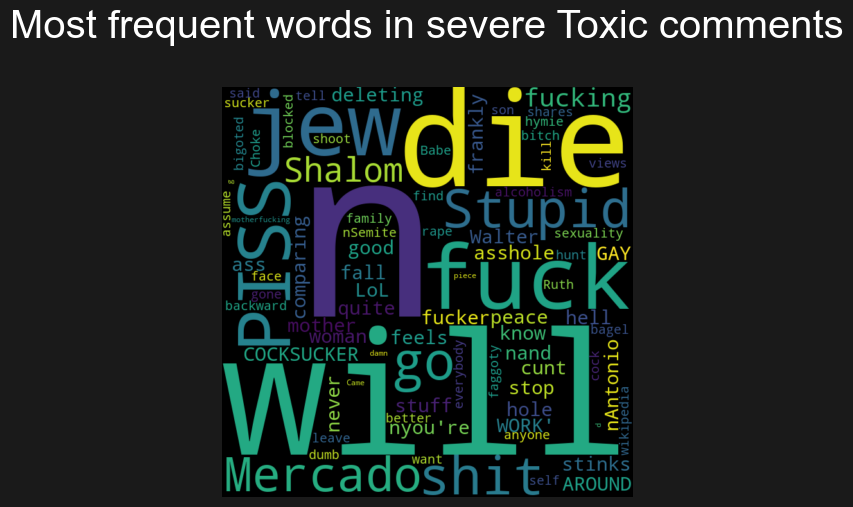

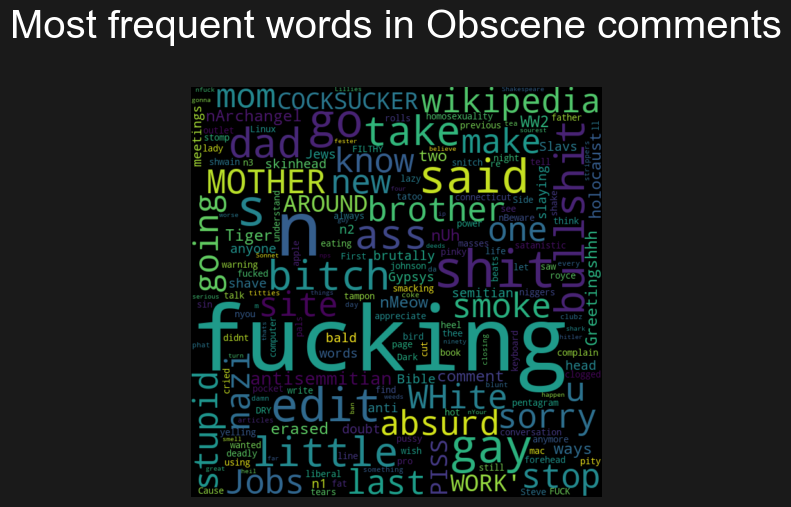

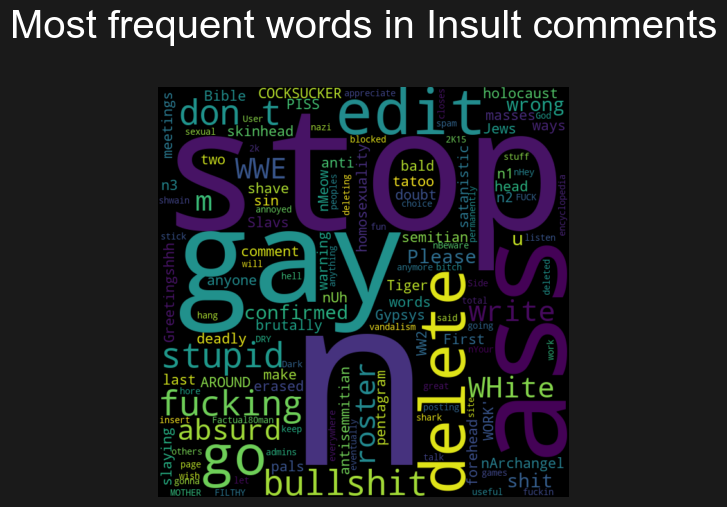

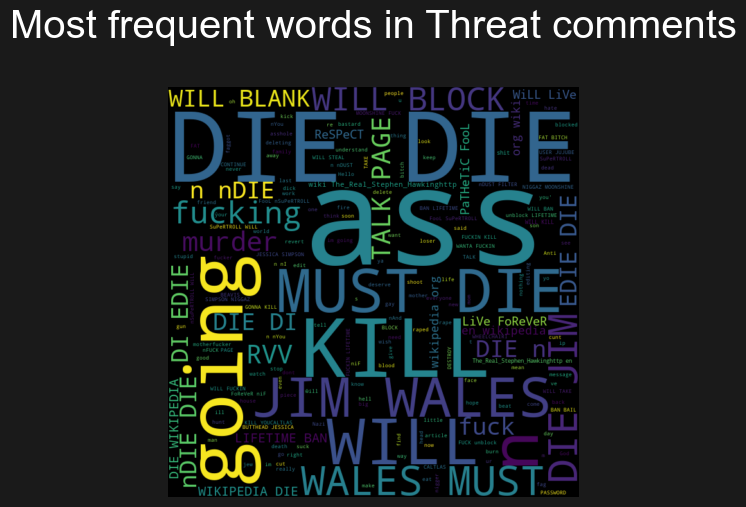

In [74]:
def word_plot(column,text):
    
    comments = train_df['comment_text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()
    
word_plot(train_df['toxic'], "Toxic comments")
word_plot(train_df['severe_toxic'],"severe Toxic comments")
word_plot(train_df['obscene'],"Obscene comments")
word_plot(train_df['insult'],"Insult comments")
word_plot(train_df['threat'],"Threat comments")

## Unique words count distribution

In [75]:
count_word = train_df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
count_unique_word = train_df["comment_text"].apply(lambda x: len(set(str(x).split())))

In [76]:
unique_percent = count_unique_word*100/count_word
unique_percent

0          95.348837
1         100.000000
2          92.857143
3          72.566372
4         100.000000
             ...    
159566     93.617021
159567    100.000000
159568    100.000000
159569     92.000000
159570     88.888889
Name: comment_text, Length: 159571, dtype: float64

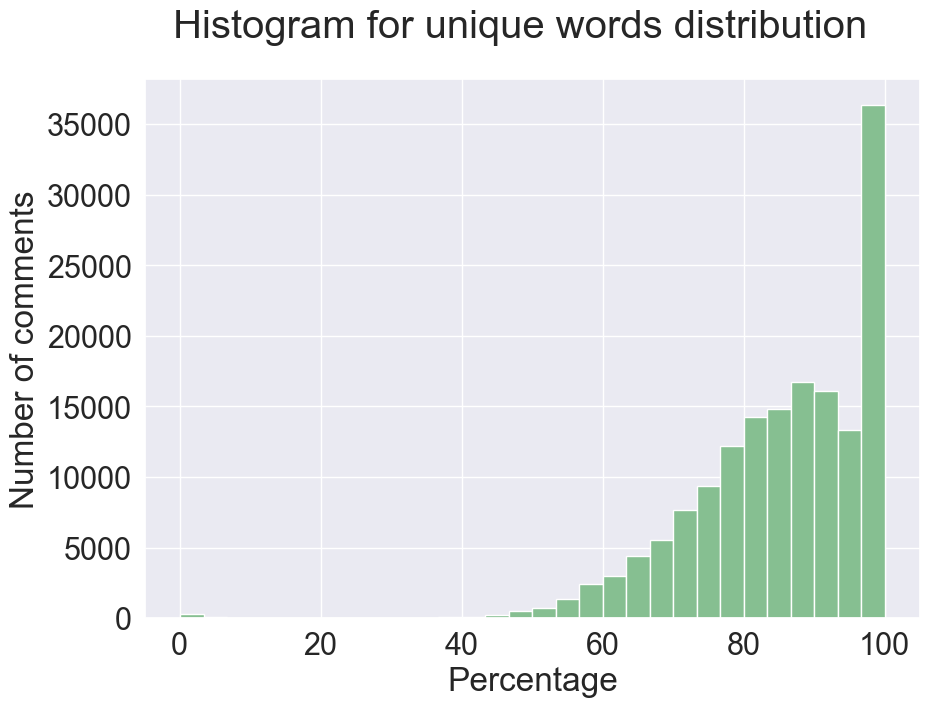

In [77]:
# plot unique words distribution for comments
unique_percent.hist(bins=30, figsize=(10,7), color='#86bf91')
plt.suptitle("Histogram for unique words distribution")
plt.xlabel("Percentage")
plt.ylabel("Number of comments")
plt.show()

## Labels Distribution

/var/folders/2_/3_dk3gg52t50907tw5l75j540000gp/T/ipykernel_93833/3255671611.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax= sns.barplot(x=x.index,y=x.values,palette=palette)


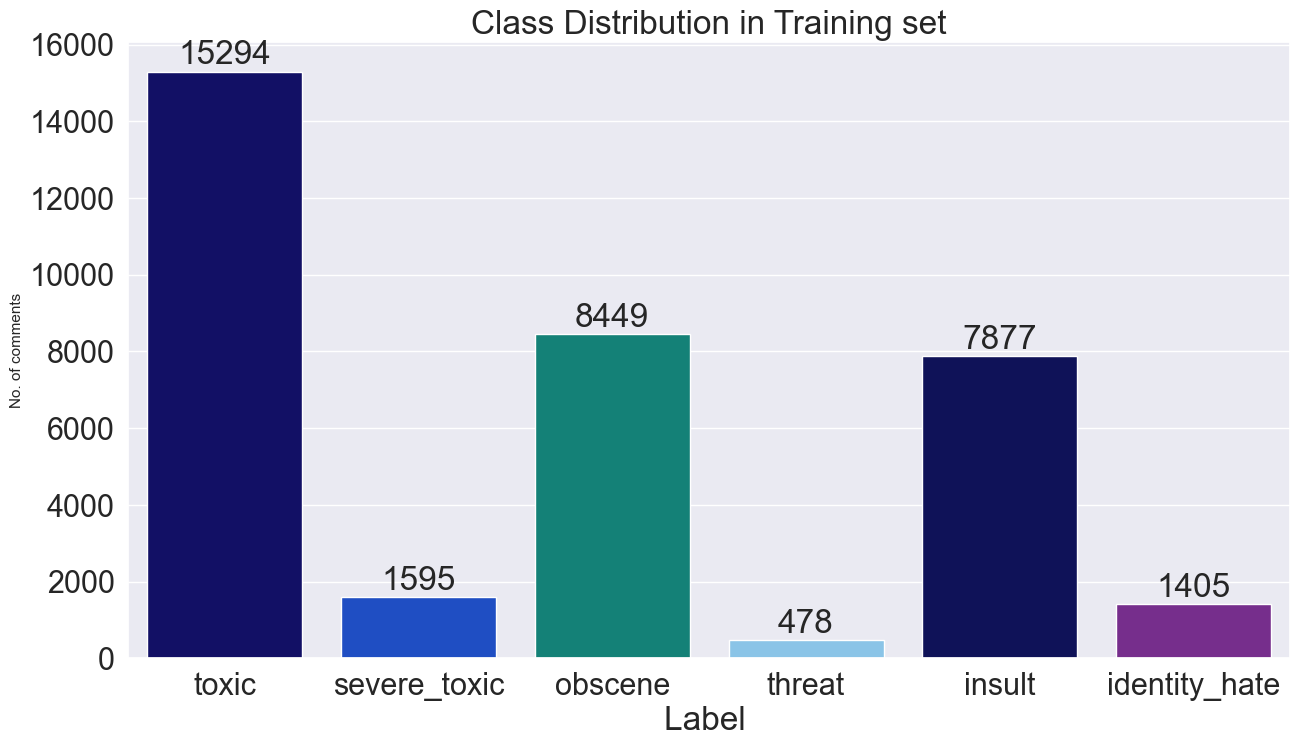

In [78]:
colors_ = ["deep blue","blue", "teal", "lightblue","darkblue","purple"]

palette= sns.xkcd_palette(colors_)

x = train_df.iloc[:,2:].sum()

plt.figure(figsize=(15,8))

ax= sns.barplot(x=x.index,y=x.values,palette=palette)
plt.title("Class Distribution in Training set")
plt.xlabel('Label ')
plt.ylabel('No. of comments', fontsize=11)

patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom',ha='center')

plt.show()

## Plot Distribution of Training Labels

/var/folders/2_/3_dk3gg52t50907tw5l75j540000gp/T/ipykernel_93833/788798618.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)


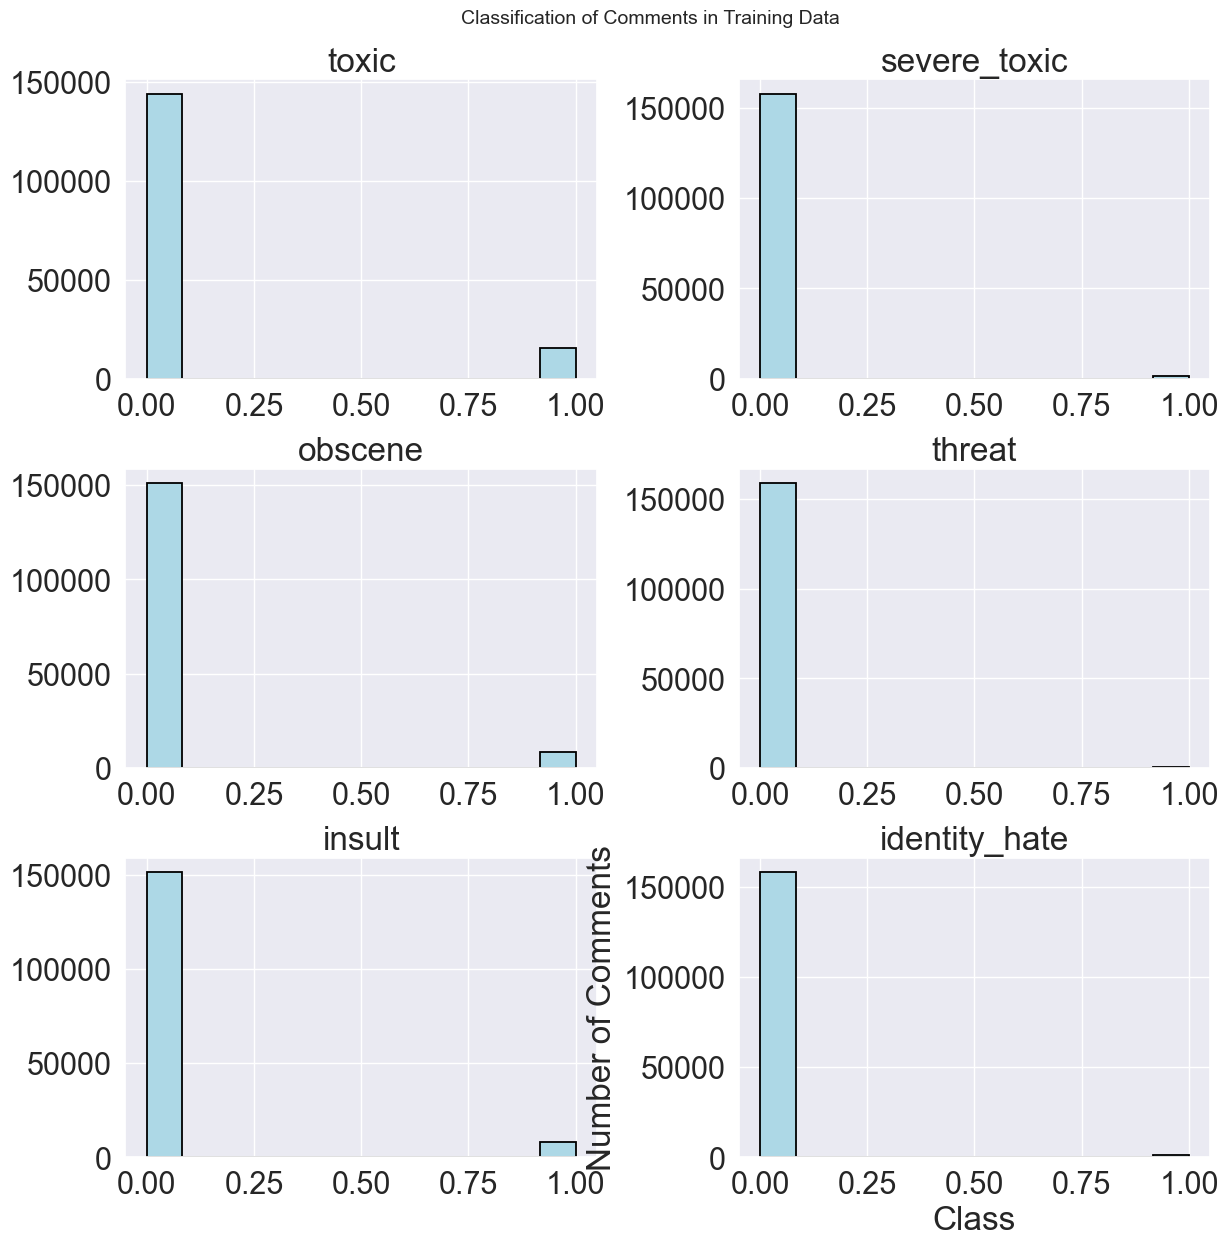

In [79]:
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Training Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

# It can be observed that there is a high imbalance among the classes
# Most of the values are zero for all classes

## Heatmap for Training Data


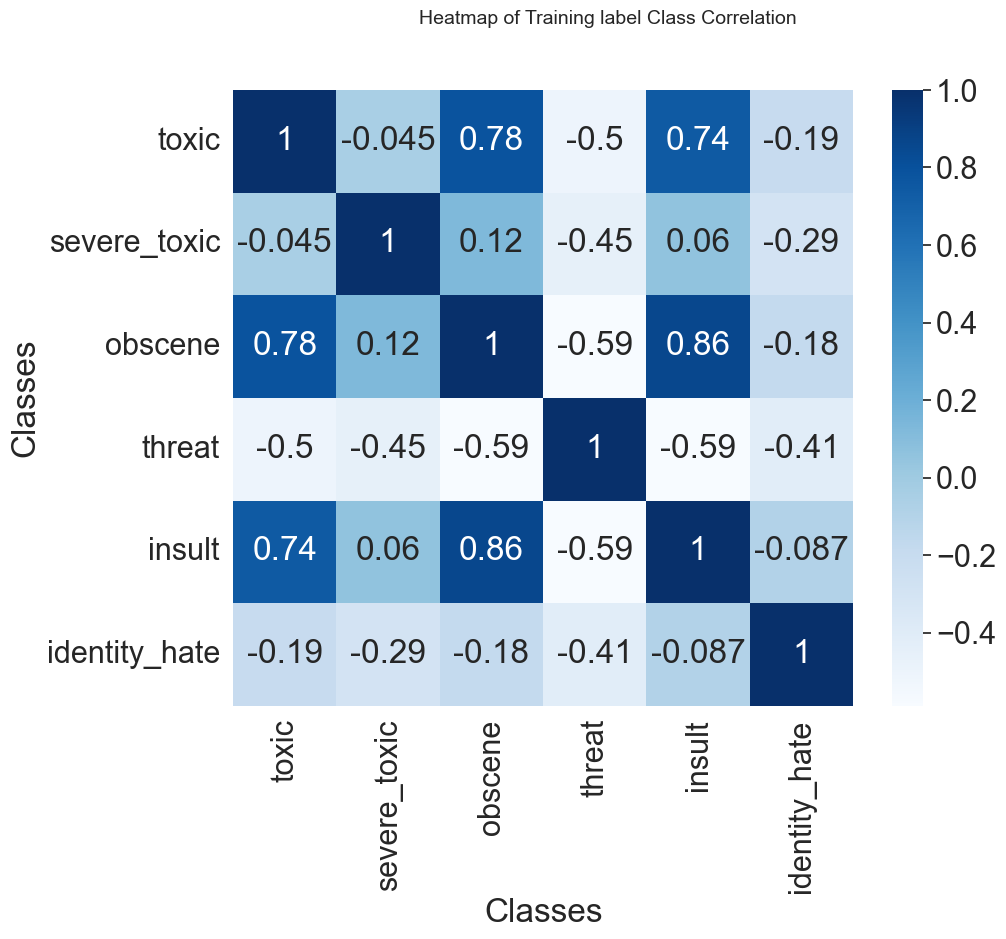

In [80]:
# Select only numerical columns
numerical_cols = train_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numerical_cols.corr()


fig = plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix.corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

In [81]:
correlation_val =  corr_matrix.corr()
correlation_val

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,-0.045115,0.783739,-0.503162,0.743056,-0.194231
severe_toxic,-0.045115,1.000000,0.124960,-0.448630,0.059961,-0.293004
obscene,0.783739,0.124960,1.000000,-0.586154,0.861719,-0.183382
threat,-0.503162,-0.448630,-0.586154,1.000000,-0.588746,-0.413463
insult,0.743056,0.059961,0.861719,-0.588746,1.000000,-0.086896
identity_hate,-0.194231,-0.293004,-0.183382,-0.413463,-0.086896,1.000000


In [82]:
abs(correlation_val) >= 0.6

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,True,False,True,False,True,False
severe_toxic,False,True,False,False,False,False
obscene,True,False,True,False,True,False
threat,False,False,False,True,False,False
insult,True,False,True,False,True,False
identity_hate,False,False,False,False,False,True


Some classes are highly positively corelated to others Correlation>60%

-toxic and insult (0.6475)
- toxic and obscene (0.6765)
- obscene and insult (0.7412)
  
This means that if a comment is toxic then there is a 67.6% chance it is also obscene and 64.7% chance that it is also classified as insult.
Obscene and insult comments are the most correlated with correlation of 74.1%

In [83]:
print("Distribution of Training Classes in Percentage:")
print()

print((train_df['toxic'].value_counts()/159571)*100)
print()
print(train_df['severe_toxic'].value_counts()/159571 *100)
print()
print(train_df['obscene'].value_counts()/159571 *100)
print()
print(train_df['threat'].value_counts()/159571 *100)
print()
print(train_df['insult'].value_counts()/159571 *100)
print()
print(train_df['identity_hate'].value_counts()/159571 *100)
print()

Distribution of Training Classes in Percentage:

toxic
0    90.415552
1     9.584448
Name: count, dtype: float64

severe_toxic
0    99.000445
1     0.999555
Name: count, dtype: float64

obscene
0    94.705178
1     5.294822
Name: count, dtype: float64

threat
0    99.700447
1     0.299553
Name: count, dtype: float64

insult
0    95.063639
1     4.936361
Name: count, dtype: float64

identity_hate
0    99.119514
1     0.880486
Name: count, dtype: float64



## Observation <a id="idc5"></a>

- It can be observed that most of the values are 0
- Very few percentage of values in classes as labelled as 1 which means there is a high imbalance of classes
- Class "threat" has the highest imbalance with only 0.29% of classes labeled as 1. This means that it would be difficult to classify this class correctly in the test set as very few comments being a threat are present.
- Some undersampling or oversampling should be performed to remove imbalance
- Stratified sampling by splitting data into training and validation will also be done


- 143346 rows out of 159571 rows in training data do not have any label as 1.
- Or in other words approx 90% of the comments are untoxic.
- There is a high chance of overfitting and getting a good accuracy with a model which predicts almost all comments as not toxic.
- The problem is to fit the data such that it also predicts the toxicity and the type of toxicity accurately.

# Analysis Using Deep Learning Models




I will be using two deep learning models to test the results.

1. DistilBert transformer model
2. bart-large-mnli

I will be fine tuning a DistilBert transformer model for the Toxic Comment MultiLabel Classification problem. This is one of the most common business problems where a given piece of text/sentence/document needs to be classified into one or more of categories out of the given list.

bart-large-mnli for zero classification.

Each comment can be marked for multiple categories. If the comment is `toxic` and `obscene`, then for both those headers the value will be `1` and for the others it will be `0`.


 - Language Model Used:
	 - DistilBERT is a smaller transformer model as compared to BERT or Roberta. It is created by process of distillation applied to Bert.  
	 - [Blog-Post](https://medium.com/huggingface/distilbert-8cf3380435b5)
	 - [Research Paper](https://arxiv.org/pdf/1910.01108)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/distilbert.html)


 - Hardware Requirements:
	 - Python 3.9 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup


 - Script Objective:
	 - The objective of this script is to fine tune DistilBERT to be able to label a comment  into the following categories:
		 - `toxic`
		 - `severe_toxic`
		 - `obscene`
		 - `threat`
		 - `insult`
		 - `identity_hate`

---
***NOTE***
- *It is to be noted that the overall mechanisms for a multiclass and multilabel problems are similar, except for few differences namely:*
	- *Loss function is designed to evaluate all the probability of categories individually rather than as compared to other categories. Hence the use of `BCE` rather than `Cross Entropy` when defining loss.*
	- *Sigmoid of the outputs calcuated to rather than Softmax. Again for the reasons defined in the previous point*

## Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes. 
*Assuming that the `train.csv` is already downloaded, unzipped and saved in your `data` folder*

* First step will be to remove the **id** column from the data.
* The values of all the categories and coverting it into a list.
* The list is appened as a new column names as **labels**.
* Drop all the labels columns

In [84]:
from torch import cuda
device = torch.device('cuda' if cuda.is_available() else 'cpu')

# device = torch.device('mps' if torch.backends.mps.is_available() else 
#                       'cuda' if torch.cuda.is_available() else 'cpu')

print(f"Current device: {device}")

Current device: cpu


In [85]:
train_data = pd.read_csv('data/train.csv.zip')
print(f"Total Training Records : {len(train_data)}")

train_data.head()

Total Training Records : 159571


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Removing id column and preparing labels into the single list column

In [86]:
train_data.drop(['id'], inplace=True, axis=1)
train_data['labels'] = train_data.iloc[:, 1:].values.tolist()
train_data.drop(train_data.columns.values[1:-1].tolist(), inplace=True, axis=1)
train_data.head()

,comment_text,labels
0,Explanation\nWhy the edits made under my usern...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\nMore\nI can't make any real suggestions on ...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


## Data Cleaning & Removing noise

- Lower case
- Remove extra space

In [87]:
train_data["comment_text"] = train_data["comment_text"].str.lower()
train_data["comment_text"] = train_data["comment_text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

## Advance Preprocessing 

In [88]:
# Regex to remove all Non-Alpha Numeric and space
# special_character_removal=re.compile(r'[^?!.,:a-z\d ]',re.IGNORECASE)
# regex to replace all numerics
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def clean_text(text):
    # Clean the text, with the option to remove stopwords and to stem words.
    # dirty words
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)
    
#     if False:
#         # Drop the image
#         text = re.sub(r"image:[a-zA-Z0-9]*\.jpg", " ", text)
#         text = re.sub(r"image:[a-zA-Z0-9]*\.png", " ", text)
#         text = re.sub(r"image:[a-zA-Z0-9]*\.gif", " ", text)
#         text = re.sub(r"image:[a-zA-Z0-9]*\.bmp", " ", text)

#         # Drop css
#         text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ",text)
#         text = re.sub(r"\{\|[^\}]*\|\}", " ", text)
        
#         # Clean templates
#         text = re.sub(r"\[?\[user:.*\]", " ", text)
#         text = re.sub(r"\[?\[user:.*\|", " ", text)        
#         text = re.sub(r"\[?\[wikipedia:.*\]", " ", text)
#         text = re.sub(r"\[?\[wikipedia:.*\|", " ", text)
#         text = re.sub(r"\[?\[special:.*\]", " ", text)
#         text = re.sub(r"\[?\[special:.*\|", " ", text)
#         text = re.sub(r"\[?\[category:.*\]", " ", text)
#         text = re.sub(r"\[?\[category:.*\|", " ", text)
    

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"\!", " ! ", text)
    text = re.sub(r"\"", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
#     text = re.sub(r"\s{2,}", " ", text)
    
    
#     text = text.replace("\n", " ")
#     text = text.replace("\t", " ")
#     text = text.replace("\b", " ")
#     text = text.replace("\r", " ")
#     text = replace_numbers.sub(' ', text)
    #text = special_character_removal.sub('',text)

    return text



# def clean_text(train, test):
#     repl = {
#         "&lt;3": " good ",
#         ":d": " good ",
#         ":dd": " good ",
#         ":p": " good ",
#         "8)": " good ",
#         ":-)": " good ",
#         ":)": " good ",
#         ";)": " good ",
#         "(-:": " good ",
#         "(:": " good ",
#         "yay!": " good ",
#         "yay": " good ",
#         "yaay": " good ",
#         "yaaay": " good ",
#         "yaaaay": " good ",
#         "yaaaaay": " good ",
#         ":/": " bad ",
#         ":&gt;": " sad ",
#         ":')": " sad ",
#         ":-(": " bad ",
#         ":(": " bad ",
#         ":s": " bad ",
#         ":-s": " bad ",
#         "&lt;3": " heart ",
#         ":d": " smile ",
#         ":p": " smile ",
#         ":dd": " smile ",
#         "8)": " smile ",
#         ":-)": " smile ",
#         ":)": " smile ",
#         ";)": " smile ",
#         "(-:": " smile ",
#         "(:": " smile ",
#         ":/": " worry ",
#         ":&gt;": " angry ",
#         ":')": " sad ",
#         ":-(": " sad ",
#         ":(": " sad ",
#         ":s": " sad ",
#         ":-s": " sad ",
#         r"\br\b": "are",
#         r"\bu\b": "you",
#         r"\bhaha\b": "ha",
#         r"\bhahaha\b": "ha",
#         r"\bdon't\b": "do not",
#         r"\bdoesn't\b": "does not",
#         r"\bdidn't\b": "did not",
#         r"\bhasn't\b": "has not",
#         r"\bhaven't\b": "have not",
#         r"\bhadn't\b": "had not",
#         r"\bwon't\b": "will not",
#         r"\bwouldn't\b": "would not",
#         r"\bcan't\b": "can not",
#         r"\bcannot\b": "can not",
#         r"\bi'm\b": "i am",
#         "m": "am",
#         "r": "are",
#         "u": "you",
#         "haha": "ha",
#         "hahaha": "ha",
#         "don't": "do not",
#         "doesn't": "does not",
#         "didn't": "did not",
#         "hasn't": "has not",
#         "haven't": "have not",
#         "hadn't": "had not",
#         "won't": "will not",
#         "wouldn't": "would not",
#         "can't": "can not",
#         "cannot": "can not",
#         "i'm": "i am",
#         "m": "am",
#         "i'll" : "i will",
#         "its" : "it is",
#         "it's" : "it is",
#         "'s" : " is",
#         "that's" : "that is",
#         "weren't" : "were not",
#     }

#     keys = [i for i in repl.keys()]

#     new_train_data = []
#     new_test_data = []
#     ltr = train['comment_text'].tolist()
#     lte = test['comment_text'].tolist()
#     for i in ltr:
#         arr = str(i).split()
#         xx = ""
#         for j in arr:
#             j = str(j).lower()
#             if j[:4] == 'http' or j[:3] == 'www':
#                 continue
#             if j in keys:
#                 # print("inn")
#                 j = repl[j]
#             xx += j + ' '
#         new_train_data.append(xx)
#     for i in lte:
#         arr = str(i).split()
#         xx = ''
#         for j in arr:
#             j = str(j).lower()
#             if j[:4] == 'http' or j[:3] == 'www':
#                 continue
#             if j in keys:
#                 # print("inn")
#                 j = repl[j]
#             xx += j + ' '
#         new_test_data.append(xx)
#     train2['comment_text'] = new_train_data
#     test2['comment_text'] = new_test_data
#     print_step('crap removed')
#     trate = train2['comment_text'].tolist()
#     tete = test2['comment_text'].tolist()
#     for i, c in enumerate(trate):
#         trate[i] = re.sub('[^a-zA-Z ?!]+', '', str(trate[i]).lower())
#     for i, c in enumerate(tete):
#         tete[i] = re.sub('[^a-zA-Z ?!]+', '', tete[i])
#     train2['comment_text'] = trate
#     test2['comment_text'] = tete
#     print_step('only alphabets')

#     train2['comment_text'].fillna('missing', inplace=True)
#     test2['comment_text'].fillna('missing', inplace=True)
#     print_step('Filling missing')
#     print('Train shape: {}'.format(train.shape))
#     print('Test shape: {}'.format(test.shape))
#     return train2, test2


In [89]:
train_data.head()

,comment_text,labels
0,explanation why the edits made under my userna...,"[0, 0, 0, 0, 0, 0]"
1,d'aww! he matches this background colour i'm s...,"[0, 0, 0, 0, 0, 0]"
2,"hey man, i'm really not trying to edit war. it...","[0, 0, 0, 0, 0, 0]"
3,""" more i can't make any real suggestions on im...","[0, 0, 0, 0, 0, 0]"
4,"you, sir, are my hero. any chance you remember...","[0, 0, 0, 0, 0, 0]"


In [90]:
train_data["comment_text"] = train_data["comment_text"].progress_apply(clean_text)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [91]:
train_data.head()

,comment_text,labels
0,explanation why the edits made under my userna...,"[0, 0, 0, 0, 0, 0]"
1,d aww ! he matches this background colour i...,"[0, 0, 0, 0, 0, 0]"
2,hey man i am really not trying to edit war ...,"[0, 0, 0, 0, 0, 0]"
3,more i cannot make any real suggestions on ...,"[0, 0, 0, 0, 0, 0]"
4,you sir are my hero any chance you remember...,"[0, 0, 0, 0, 0, 0]"


## Training Parameters 
Defining some key variables that will be used later on in the training

In [92]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
EPOCHS = 1
LEARNING_RATE = 1e-05
NUM_WORKERS = 2

## Preparing the Dataset and Dataloader <a id='section04'></a>
We will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by creation of MultiLabelDataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing. 
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

### *MultiLabelDataset* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe`, `max_length` and `eval_mode` as input and generate tokenized output and tags that is used by the BERT model for training. 
- We are using the DistilBERT tokenizer to tokenize the data in the `text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids`

- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)
- `targets` is the list of categories labled as `0` or `1` in the dataframe. 
- The *MultiLabelDataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training. 

### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [93]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len: int, eval_mode: bool = False):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.text = dataframe.comment_text
        self.eval_mode = eval_mode 
        if self.eval_mode is False:
            self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        output = {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }
                
        if self.eval_mode is False:
            output['targets'] = torch.tensor(self.targets.iloc[index], dtype=torch.float)
                
        return output

## Loading tokenizer and generating training set

In [94]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)

In [95]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': NUM_WORKERS
                }
training_loader = DataLoader(training_set, **train_params)


## Neural Network for Fine Tuning

### Neural Network
 - We will be creating a neural network with the `DistilBERTClass`. 
 - This network will have the `DistilBERT` model.  Follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regulariaztion** and **Classification** respectively. 
 - In the forward loop, there are 2 output from the `DistilBERTClass` layer.
 - The second output `output_1` or called the `pooled output` is passed to the `Drop Out layer` and the subsequent output is given to the `Linear layer`. 
 - Keep note the number of dimensions for `Linear Layer` is **6** because that is the total number of categories in which we are looking to classify our model.
 - The data will be fed to the `DistilBERTClass` as defined in the dataset. 
 - Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference.

In [96]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
        
class DistilBERTClass(torch.nn.Module):
    
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output


## Loading Neural Network model

In [97]:
model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

## Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [98]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [99]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)


## Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process. 

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network. 

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size. 
- Subsequent output from the model and the actual category are compared to calculate the loss. 
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a miniscule loss of 0.05 i.e. the network output is extremely close to the actual output.

In [100]:
def train(epoch):
    
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()

In [101]:
for epoch in range(EPOCHS):
    train(epoch)

## Model 1 Evaluation

ROC Curve and AUC: Each label’s ROC curve is calculated using roc_curve, and the AUC is calculated with auc. These are plotted on a single graph to compare the model’s performance across labels.

Specificity Calculation: Specificity is calculated for each label based on true negatives and false positives.

Precision-Recall Curve: The PrecisionRecallDisplay.from_predictions function generates the precision-recall curve for each label.

Overall Metrics: Overall averages are calculated for F1-score, precision, recall, accuracy, specificity, and AUC.

In [124]:
test_data = pd.read_csv('data/test.csv.zip')
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [103]:
test_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN, eval_mode = True)
testing_params = {'batch_size': TRAIN_BATCH_SIZE,
               'shuffle': False,
               'num_workers': 2
                }
test_loader = DataLoader(test_set, **testing_params)

In [104]:
all_test_pred = []

def test(epoch):
    model.eval()
    
    with torch.inference_mode():
    
        for _, data in tqdm(enumerate(test_loader, 0)):


            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            outputs = model(ids, mask, token_type_ids)
            probas = torch.sigmoid(outputs)

            all_test_pred.append(probas)
    return probas

In [105]:
y_pred = test(model)

In [106]:
test_labels = pd.read_csv("data/test_labels.csv.zip")

In [107]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [109]:
y_pred.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.995929,0.527431,0.978008,0.103378,0.954302,0.493032
1,0000247867823ef7,0.001001,0.000225,0.000289,0.000187,0.000310,0.000231
2,00013b17ad220c46,0.000768,0.000258,0.000324,0.000191,0.000312,0.000270
3,00017563c3f7919a,0.000656,0.000307,0.000280,0.000263,0.000328,0.000266
4,00017695ad8997eb,0.001372,0.000194,0.000285,0.000175,0.000321,0.000214


In [120]:
y_true = pd.read_csv("data/test_labels.csv.zip")  

y_true = y_true.replace(-1, 0)

threshold = 0.7
y_pred_binary = (y_pred.iloc[:, 1:] > threshold).astype(int)


toxic - F1 Score: 0.2802, Precision: 0.1683, Recall: 0.8353, Accuracy: 0.8294, Specificity: 0.8291, AUC: 0.9008
severe_toxic - F1 Score: 0.0906, Precision: 0.1472, Recall: 0.0654, Accuracy: 0.9969, Specificity: 0.9991, AUC: 0.9796
obscene - F1 Score: 0.2582, Precision: 0.1576, Recall: 0.7144, Accuracy: 0.9011, Specificity: 0.9057, AUC: 0.9298
threat - F1 Score: 0.3137, Precision: 0.2333, Recall: 0.4787, Accuracy: 0.9971, Specificity: 0.9978, AUC: 0.9921
insult - F1 Score: 0.2803, Precision: 0.1873, Recall: 0.5568, Accuracy: 0.9360, Specificity: 0.9447, AUC: 0.9373
identity_hate - F1 Score: 0.2720, Precision: 0.2053, Recall: 0.4031, Accuracy: 0.9900, Specificity: 0.9927, AUC: 0.9814


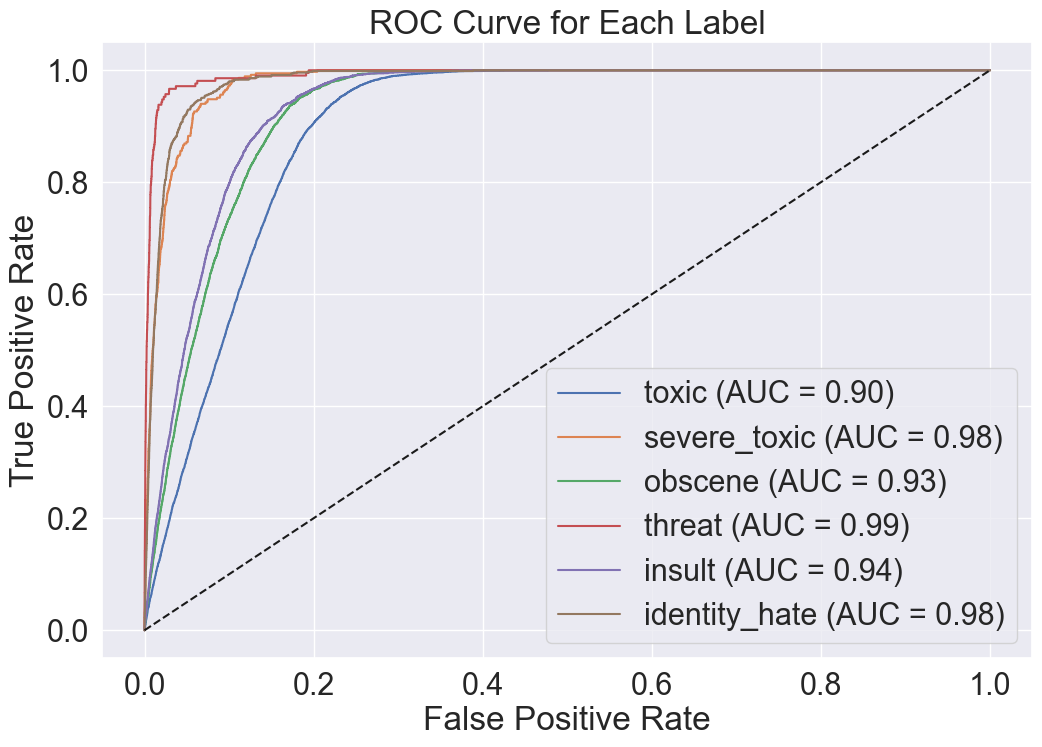

<Figure size 1200x800 with 0 Axes>

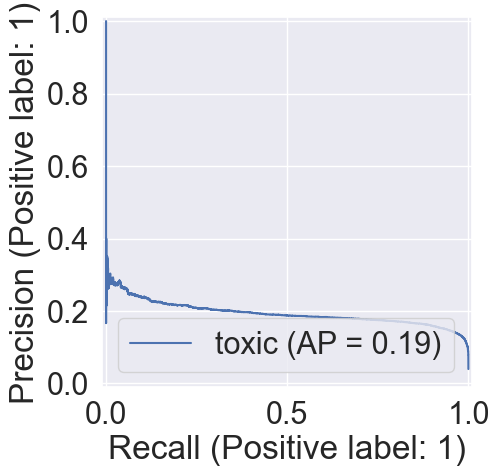

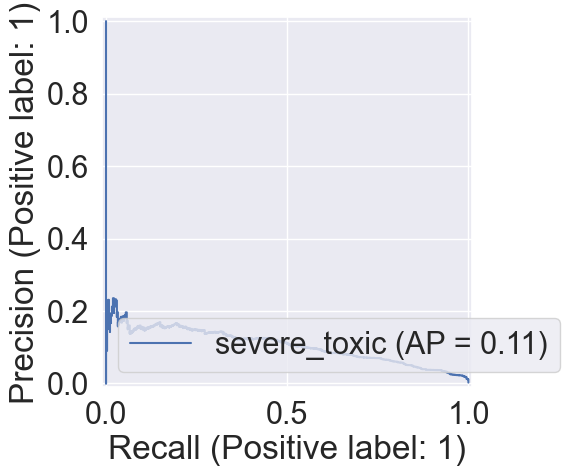

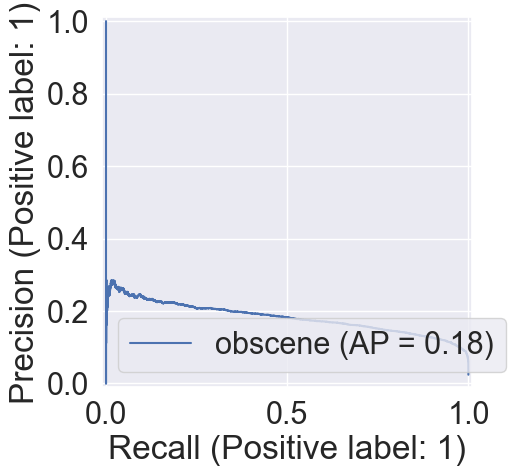

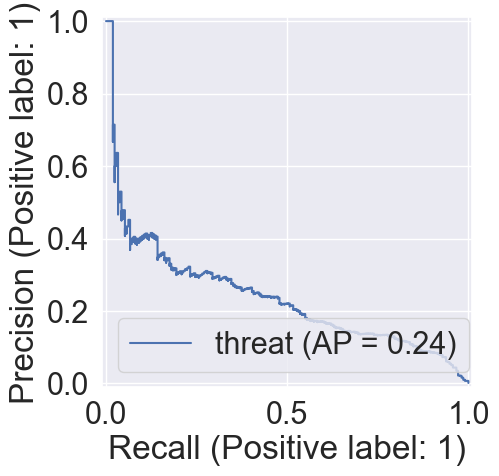

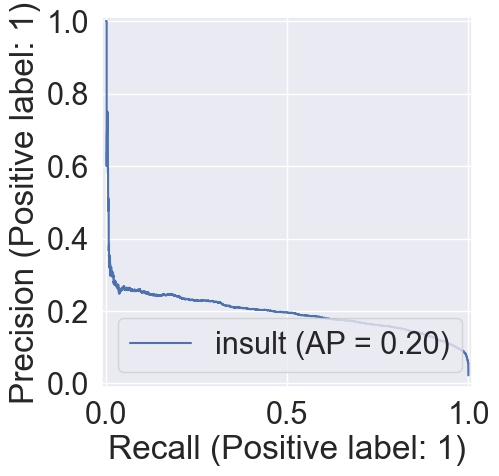

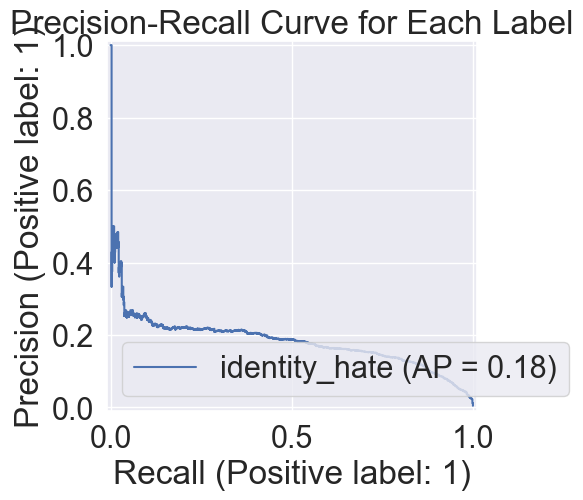


Overall Metrics - F1 Score: 0.2492, Precision: 0.1832, Recall: 0.5089, Accuracy: 0.9417, Specificity: 0.9449, AUC: 0.9535


In [123]:
# Initialize lists to store metrics for each label
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
f1_scores = []
precisions = []
recalls = []
accuracies = []
specificities = []
auc_scores = []

plt.figure(figsize=(12, 8))
for label in labels:

    f1 = f1_score(y_true[label], y_pred_binary[label])
    precision = precision_score(y_true[label], y_pred_binary[label])
    recall = recall_score(y_true[label], y_pred_binary[label])
    accuracy = accuracy_score(y_true[label], y_pred_binary[label])
    balanced_accuracy = balanced_accuracy_score(y_true[label], y_pred_binary[label])
    

    tn = ((y_true[label] == 0) & (y_pred_binary[label] == 0)).sum()
    fp = ((y_true[label] == 0) & (y_pred_binary[label] == 1)).sum()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    

    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    specificities.append(specificity)
    

    fpr, tpr, _ = roc_curve(y_true[label], y_pred[label])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    

    print(f"{label} - F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, Specificity: {specificity:.4f}, AUC: {roc_auc:.4f}")


    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Label')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(12, 8))
for label in labels:
    PrecisionRecallDisplay.from_predictions(y_true[label], y_pred[label], name=label)

plt.title('Precision-Recall Curve for Each Label')
plt.show()


overall_f1 = f1_score(y_true[labels], y_pred_binary[labels], average='macro')
overall_precision = precision_score(y_true[labels], y_pred_binary[labels], average='macro')
overall_recall = recall_score(y_true[labels], y_pred_binary[labels], average='macro')
overall_accuracy = accuracy_score(y_true[labels].values.ravel(), y_pred_binary[labels].values.ravel())
overall_specificity = sum(specificities) / len(specificities)
overall_auc = sum(auc_scores) / len(auc_scores)

print(f"\nOverall Metrics - F1 Score: {overall_f1:.4f}, Precision: {overall_precision:.4f}, Recall: {overall_recall:.4f}, Accuracy: {overall_accuracy:.4f}, Specificity: {overall_specificity:.4f}, AUC: {overall_auc:.4f}")


## Conclusion

### AUC and ROC Analysis
   - The ROC curves for each label demonstrate the model’s ability to discriminate between the positive and negative classes for each type of toxic content. The AUC values are high across all categories, ranging from 0.90 to 0.99, which suggests that the model performs well in distinguishing between toxic and non-toxic comments.
   - Specifically, the model performs very well on **"threat"** (AUC = 0.99), **"severe_toxic"** (AUC = 0.98), and **"identity_hate"** (AUC = 0.98), indicating strong classification capability in these areas.
   - **"Toxic"** has the lowest AUC at 0.90, which is still reasonably good but indicates slightly less confidence in this category compared to others.

### Overall Performance Metrics
   - **F1 Score (0.2492)**: The F1 score is relatively low, which suggests a trade-off between precision and recall. This may indicate that while the model captures true positives effectively (good recall), it also has a fair number of false positives, lowering precision.
   - **Precision (0.1832)**: The low precision score indicates that the model often classifies non-toxic content as toxic, resulting in a higher number of false positives.
   - **Recall (0.5089)**: The model achieves a higher recall score, meaning it correctly identifies over half of the toxic comments across categories. This indicates that the model tends to favor recall over precision, which may be desirable in situations where catching toxic content is more important than precision.
   - **Accuracy (0.9417)**: High accuracy suggests that the model performs well on the overall dataset, largely due to the prevalence of non-toxic comments in the data. However, this metric can be misleading when dealing with imbalanced data, as it may be influenced by the model’s performance on the majority class.
   - **Specificity (0.9449)**: High specificity indicates that the model is very good at correctly identifying non-toxic comments, which aligns with the high accuracy.
   - **AUC (0.9535)**: The high average AUC score reinforces the model’s strong discrimination ability across all classes. A score of 0.9535 reflects a robust ability to separate positive and negative cases for toxic content.

   - The model shows strong performance in terms of AUC, indicating that it’s quite effective at distinguishing between toxic and non-toxic comments across different categories.
   - However, the lower precision and F1 score suggest the model struggles with false positives, which could lead to over-flagging non-toxic content as toxic.
   - If the model is intended for use in a high-stakes environment where misclassifying non-toxic comments as toxic is problematic, further tuning is recommended to improve precision and F1 score.
   - For applications prioritizing recall (e.g., catching as many toxic comments as possible), this model is well-suited, as evidenced by its relatively high recall.
  
   Overall, the model is reliable in identifying toxic content but could benefit from adjustments to reduce false positives, especially if precision is a priority for its intended application.

## Model 2: Zero shot classification

In [125]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
categories

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [128]:
task = "zero-shot-classification"
model = "facebook/bart-large-mnli"
classifier = pipeline(task, model,device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [129]:
test_samples = pd.read_csv("data/test.csv.zip")
test_samples.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [130]:
## Records
print("Number of test records: ", len(test_samples))

Number of test records:  153164


In [131]:
# checking missing values
test_samples.isnull().sum()

id              0
comment_text    0
dtype: int64

In [132]:
# Data preprocessing
test_samples["comment_text"] = test_samples["comment_text"].str.lower()
test_samples["comment_text"] = test_samples["comment_text"].str.replace(rf"([{string.punctuation}])+"," ", regex=True)
test_samples["comment_text"] = test_samples["comment_text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

In [133]:
test_samples = test_samples.replace(r'^\s*$', ".", regex=True)


In [135]:
## Predicting
test_samples['scores'] = test_samples['comment_text'].progress_apply(lambda x: classifier(x, categories, multi_label=True)['scores'])

In [ ]:
y_pred = pd.DataFrame(test_samples['scores'].tolist(), columns=categories)

In [136]:
y_true = pd.read_csv("data/test_labels.csv.zip")
y_true = y_true.replace(-1, 0)

In [137]:
y_true.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0,0,0,0,0,0
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0


In [139]:
y_pred.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.992948,0.988667,0.984063,0.953639,0.826800,0.818014
1,0000247867823ef7,0.020652,0.001811,0.000162,0.000116,0.000075,0.000059
2,00013b17ad220c46,0.213046,0.049738,0.044761,0.026517,0.022128,0.005475
3,00017563c3f7919a,0.294970,0.294220,0.163352,0.012402,0.007753,0.003055
4,00017695ad8997eb,0.143865,0.105552,0.067218,0.055986,0.021328,0.012634


In [140]:
threshold = 0.7
y_pred_binary = (y_pred.iloc[:, 1:] > threshold).astype(int)


toxic - F1 Score: 0.1235, Precision: 0.0663, Recall: 0.8974, Accuracy: 0.4934, Specificity: 0.4767, AUC: 0.7722
severe_toxic - F1 Score: 0.0117, Precision: 0.0059, Recall: 0.9619, Accuracy: 0.6116, Specificity: 0.6107, AUC: 0.8876
obscene - F1 Score: 0.1129, Precision: 0.0609, Recall: 0.7762, Accuracy: 0.7062, Specificity: 0.7045, AUC: 0.7991
threat - F1 Score: 0.0099, Precision: 0.0050, Recall: 0.8436, Accuracy: 0.7685, Specificity: 0.7684, AUC: 0.8750
insult - F1 Score: 0.1392, Precision: 0.0797, Recall: 0.5480, Accuracy: 0.8483, Specificity: 0.8552, AUC: 0.7995
identity_hate - F1 Score: 0.0678, Precision: 0.0370, Recall: 0.4003, Accuracy: 0.9488, Specificity: 0.9514, AUC: 0.8033


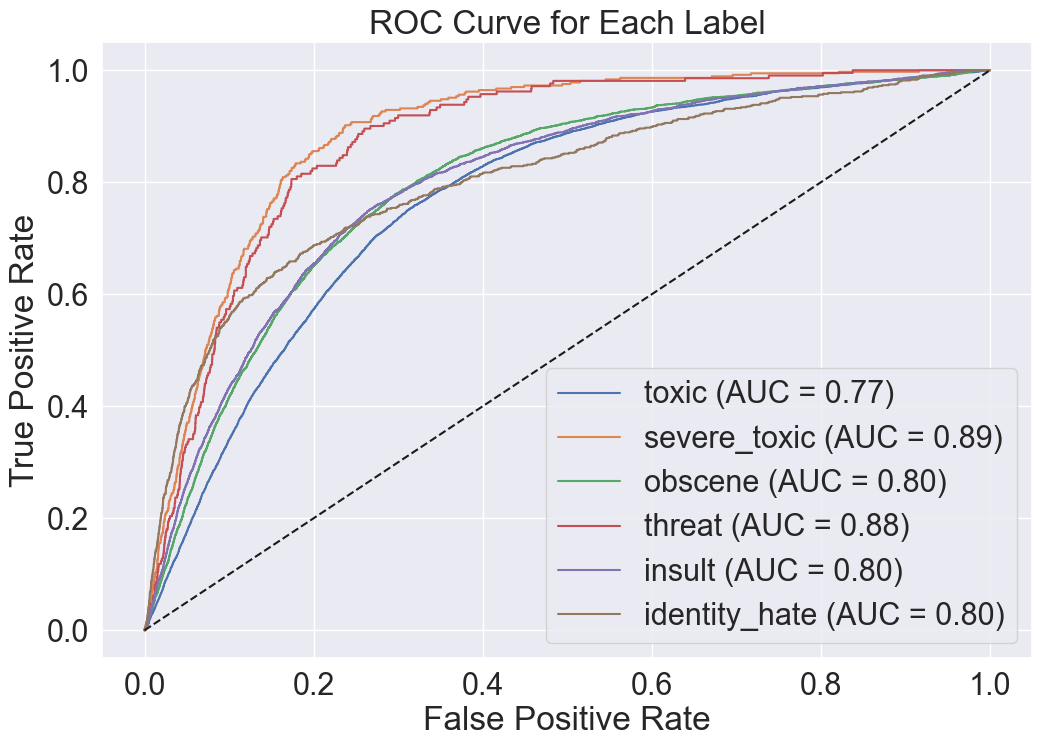

<Figure size 1200x800 with 0 Axes>

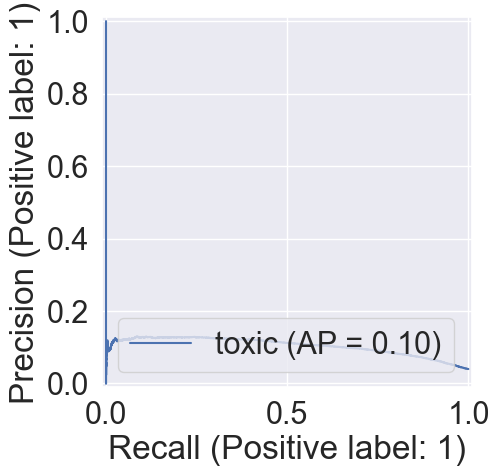

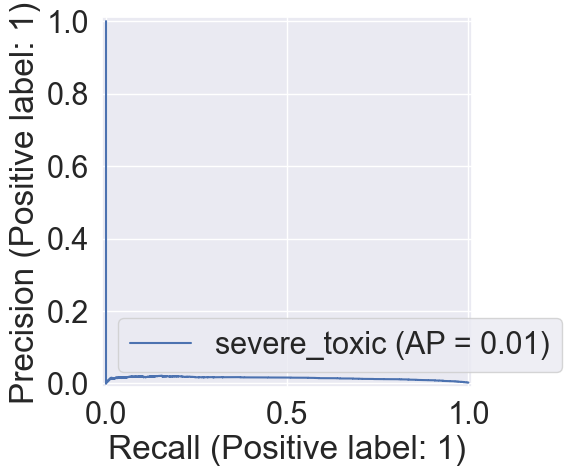

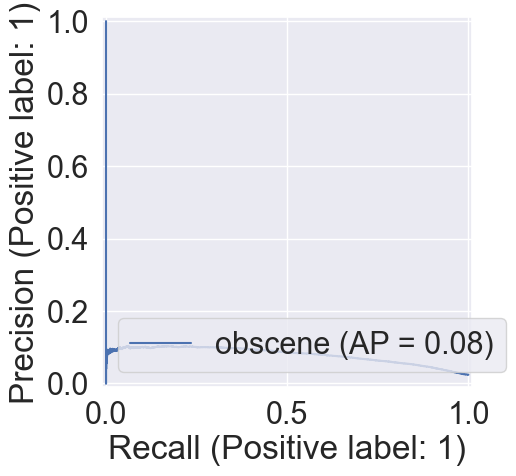

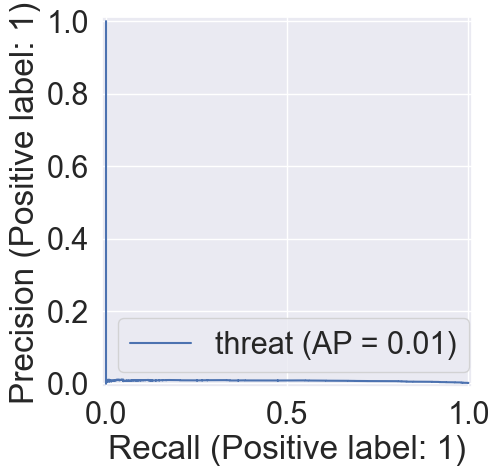

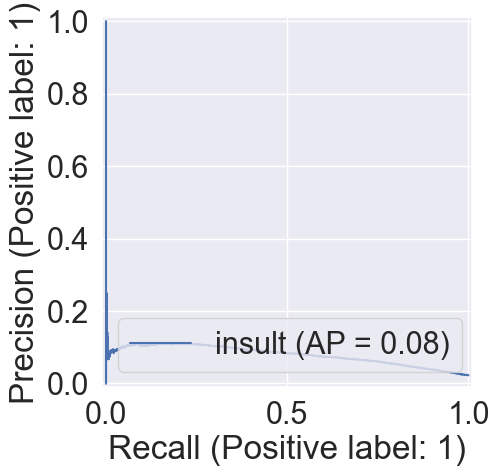

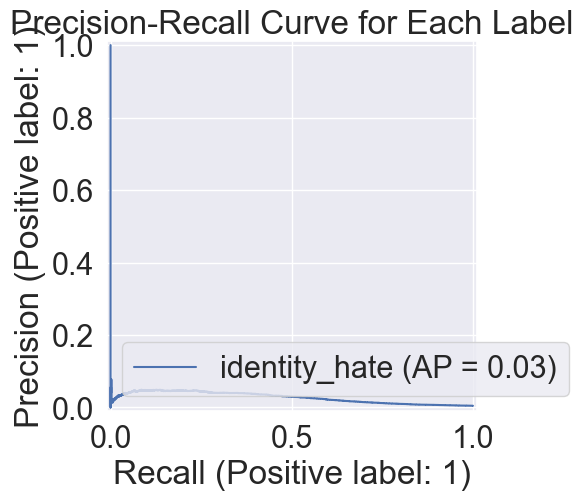


Overall Metrics - F1 Score: 0.0775, Precision: 0.0425, Recall: 0.7379, Accuracy: 0.7295, Specificity: 0.7278, AUC: 0.8228


In [141]:

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
f1_scores = []
precisions = []
recalls = []
accuracies = []
specificities = []
auc_scores = []


plt.figure(figsize=(12, 8))
for label in labels:

    f1 = f1_score(y_true[label], y_pred_binary[label])
    precision = precision_score(y_true[label], y_pred_binary[label])
    recall = recall_score(y_true[label], y_pred_binary[label])
    accuracy = accuracy_score(y_true[label], y_pred_binary[label])
    balanced_accuracy = balanced_accuracy_score(y_true[label], y_pred_binary[label])
    

    tn = ((y_true[label] == 0) & (y_pred_binary[label] == 0)).sum()
    fp = ((y_true[label] == 0) & (y_pred_binary[label] == 1)).sum()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    

    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    specificities.append(specificity)
    

    fpr, tpr, _ = roc_curve(y_true[label], y_pred[label])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    

    print(f"{label} - F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, Specificity: {specificity:.4f}, AUC: {roc_auc:.4f}")


    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Label')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(12, 8))
for label in labels:
    PrecisionRecallDisplay.from_predictions(y_true[label], y_pred[label], name=label)

plt.title('Precision-Recall Curve for Each Label')
plt.show()


overall_f1 = f1_score(y_true[labels], y_pred_binary[labels], average='macro')
overall_precision = precision_score(y_true[labels], y_pred_binary[labels], average='macro')
overall_recall = recall_score(y_true[labels], y_pred_binary[labels], average='macro')
overall_accuracy = accuracy_score(y_true[labels].values.ravel(), y_pred_binary[labels].values.ravel())
overall_specificity = sum(specificities) / len(specificities)
overall_auc = sum(auc_scores) / len(auc_scores)

print(f"\nOverall Metrics - F1 Score: {overall_f1:.4f}, Precision: {overall_precision:.4f}, Recall: {overall_recall:.4f}, Accuracy: {overall_accuracy:.4f}, Specificity: {overall_specificity:.4f}, AUC: {overall_auc:.4f}")


## Model Evaluation Conclusion for BART Zero-Shot Model


1. **AUC Analysis**:
   - The AUC scores range from 0.77 (toxic) to 0.89 (severe_toxic), indicating moderate discriminatory ability for the model across all categories. The highest AUC is observed for "severe_toxic" (0.89), while the lowest is for "toxic" (0.77).
   - The model generally performs well in distinguishing positive and negative cases, but it lacks the strong separation that higher AUC values (e.g., > 0.90) would indicate.

2. **Individual Label Analysis**:
   - **Toxic**: The model achieves a high recall of 0.8974, meaning it successfully identifies most toxic cases. However, the precision is very low (0.0663), resulting in an F1 score of 0.1235. This indicates a high number of false positives, which affects precision.
   - **Severe Toxic**: Similar to "toxic", this label has an extremely high recall (0.9619), but the precision is only 0.0059, leading to an F1 score of 0.0117. The low precision indicates significant over-flagging of non-severe toxic content.
   - **Obscene**: The model achieves an AUC of 0.80 and maintains a decent recall (0.7762). Precision, however, is low (0.0609), leading to a low F1 score (0.1129).
   - **Threat**: The model shows high recall (0.8436) but low precision (0.0050). The AUC of 0.8750 indicates moderate discriminatory ability.
   - **Insult**: For this label, the model achieves an F1 score of 0.1392, with a recall of 0.5480 and a precision of 0.0797. The AUC is 0.7995, suggesting fair performance.
   - **Identity Hate**: This label has the lowest recall among all categories (0.4003) but achieves an AUC of 0.8033. The F1 score is also low (0.0678), primarily due to low precision (0.0370).

3. **Overall Metrics**:
   - **F1 Score (0.0775)**: The F1 score is low, which indicates a weak balance between precision and recall. The model struggles with achieving high precision across the labels, resulting in significant false positives.
   - **Precision (0.0425)**: Overall precision is very low, meaning the model has a high tendency to classify non-toxic content as toxic.
   - **Recall (0.7379)**: The model performs well in terms of recall, capturing most toxic instances across the labels.
   - **Accuracy (0.7295)** and **Specificity (0.7278)**: Both metrics suggest moderate overall performance, with the model being better at correctly identifying non-toxic content.
   - **AUC (0.8228)**: The average AUC score indicates a fair discriminatory capability across labels, but the model does not excel in any specific category.

### Comparison with Bert Model

- **Discrimination Power (AUC)**:
  - The previous model had a higher overall AUC (0.9535) compared to the BART Zero-Shot model (0.8228), indicating that the previous model performed significantly better in distinguishing between toxic and non-toxic comments across all categories.
  - The AUC scores for individual labels are also higher in the previous model, suggesting more robust classification ability for each label.

- **Precision and F1 Score**:
  - The previous model achieved better overall F1 (0.2492) and precision (0.1832) scores, indicating a better balance between true positives and false positives. In contrast, the BART Zero-Shot model has much lower precision (0.0425) and F1 score (0.0775), which shows that it struggles with high false-positive rates.
  - The significant drop in precision and F1 score in the BART model indicates that it is far less precise, leading to over-flagging and potentially more noise in flagged content.

- **Recall**:
  - The BART model achieves higher recall (0.7379) than the previous model (0.5089). This suggests that the BART model is better at capturing most instances of toxic comments, though at the expense of precision.
  - For use cases prioritizing recall, the BART model might be more suitable; however, if the goal is a balanced model that minimizes false positives, the previous model is a better choice.

- **Overall Suitability**:
  - The previous model is generally more balanced in terms of precision and recall, making it better suited for applications that require both high accuracy and a reasonable false-positive rate.
  - The BART Zero-Shot model has shown strength in recall but lacks precision, making it suitable for recall-focused applications, like identifying most cases of toxicity without as much concern for false positives.



# Final Conclusion

If your application can tolerate false positives and prioritizes capturing as many toxic instances as possible, the BART Zero-Shot model could be useful. However, if a balanced approach with lower false positives is necessary, the previous model offers a more effective and reliable performance overall. Further fine-tuning may improve the BART model’s precision, but as it stands, the previous model provides a more robust solution.